In [ ]:
import math as m
import numpy as np
import matplotlib as mpl
from PIL import Image as im
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import sklearn.datasets as datasets

TEMPFILE_NAME = "temp.png"

def save_to_gif(filename, images, duration=100):
    images[0].save(
        filename,
        optimize=False,
        save_all=True,
        append_images=images[1:],
        loop=0,
        duration=duration,
    )

np.random.seed(1)

COLORS = np.array(['purple', 'green', 'blue'])

# custom CMAP
cvals  = [0, .5, 1]
colors = ['blue', 'white', 'purple']

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))

CMAP = mpl.colors.LinearSegmentedColormap.from_list("", tuples, 100)
CENTERS = [[0, 0]]
DATA, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=1,
        random_state=1
    )

def generate_xor():
    X = np.array([
        [0,0],
        [0,1],
        [1,0],
        [1,1]])
    return X, np.array([x[0]^x[1] for x in X])

def generate_line_data(t, w1, w2, b):
    X = np.array(list(filter(lambda x : w1 * x[0] + w2 * x[1] + b < -.5 or w1 * x[0] + w2 * x[1] + b > .5, t)))
    Y = np.array([0 if w1 * x[0] + w2 * x[1] + b >= 0 else 2 for x in X])
    return X, Y

def sigmoid(x):
    e = np.exp(-x)
    return 1 / (1 + e)

def generate_3_classes_1D(SIZE):
    X = np.linspace(0, 5 * SIZE, SIZE) + np.random.randn(SIZE) * 4
    Y = np.array([0 if x < 18 else 1 if x < 60 else 2 for x in X])
    return X, Y

def generate_3_classes_2D(t, w1, w2):
    f1 = lambda x1, x2: w1[0] * x1 + w1[1] * x2
    f2 = lambda x1, x2: w2[0] * x1 + w2[1] * x2
    X = np.array(list(filter(lambda x : (f1(x[0], x[1]) < -.5 or f1(x[0], x[1]) > .5) and (f2(x[0], x[1]) < -.5 or f2(x[0], x[1]) > .5), t)))
    Y = np.array([0 if f1(x[0], x[1]) >= 0 and f2(x[0], x[1]) >= 0 else 1 if (f1(x[0], x[1]) < 0 and f2(x[0], x[1]) >= 0) else 2 for x in X])
    return X, Y

# OTHER FUNCTIONS
def generate_circle_data(t):
    X = np.array(list(filter(lambda x : (x[0] - CENTERS[0][0])**2 + (x[1] - CENTERS[0][1])**2 < 1 or (x[0] - CENTERS[0][0])**2 + (x[1] - CENTERS[0][1])**2 > 1.5, t)))
    Y = np.array([0 if (x[0] - CENTERS[0][0])**2 + (x[1] - CENTERS[0][1])**2 >= 1 else 2 for x in X])
    return X, Y

def generate_square_data():
    t, _ = datasets.make_blobs(
        n_samples=200,
        centers=CENTERS,
        cluster_std=1,
        random_state=1
    )
    X = np.array(list(filter(lambda x : x[0]**2 - x[1] < .4 or x[0]**2 - x[1] > 1.1, t)))
    Y = np.array([1 if x[0]**2 - x[1] >= .75 else 0 for x in X])
    return X, Y

def generate_curve_data(t):
    X = np.array(list(filter(lambda x : m.cos(4*x[0]) - x[1] < -.5 or m.cos(4*x[0]) - x[1] > .5, t)))
    Y = np.array([1 if m.cos(4*x[0]) - x[1] >= 0 else 0 for x in X])
    return X, Y

## XOR

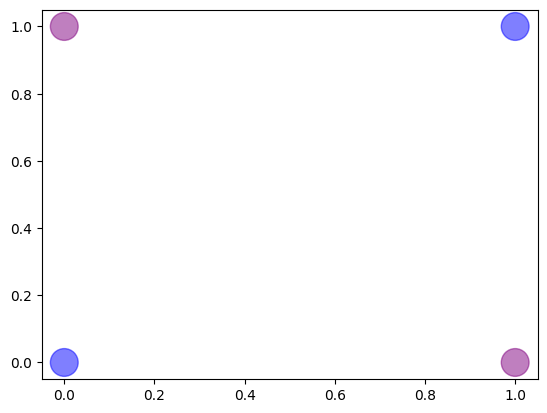

In [ ]:
X,Y = generate_xor()

# plot the data
plt.scatter(X[:,0],X[:,1],color=COLORS[Y].tolist(), s=400, alpha=.5)
plt.show()

## H1

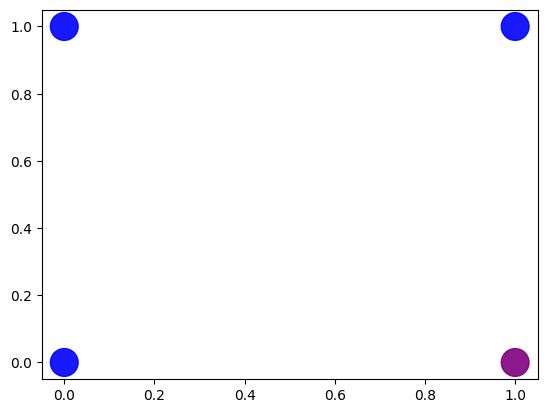

In [ ]:
def generate_h1(X):
    return np.array([x[0] & ~x[1] for x in X])

H1 = generate_h1(X)

# plot the data
plt.scatter(X[:,0],X[:,1],color=COLORS[H1].tolist(), s=400, alpha=.9)
plt.show()

## H2

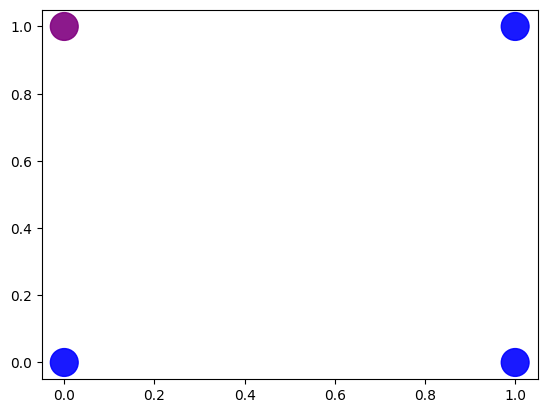

In [ ]:
def generate_h2(X):
    return np.array([~x[0] & x[1] for x in X])

H2 = generate_h2(X)

# plot the data
plt.scatter(X[:,0],X[:,1],color=COLORS[H2].tolist(), s=400, alpha=.9)
plt.show()

## Y = f(H1, H2)

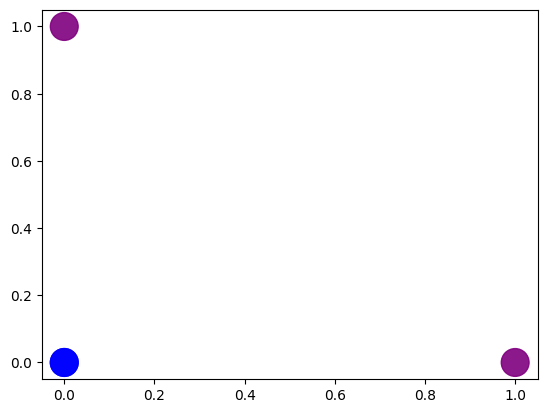

In [ ]:
plt.scatter(H1,H2,color=COLORS[Y].tolist(), s=400, alpha=.9)
plt.show()

## Concentric circles

In [ ]:
X, Y = generate_circle_data(DATA)

plt.scatter(X[:,0], X[:,1], color=COLORS[Y].tolist(), s=100, alpha=.9)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.savefig("060.png")
plt.close()

## Neural Network

In [ ]:
class LR():

    def __init__(self, model):
        self.model = model

    def _snap_learning(self, X, Y, filename):
        h = .02
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        meshData = np.c_[xx.ravel(), yy.ravel()]

        fig, ax = plt.subplots(frameon=False)
        ax.scatter(X[:, 0], X[:, 1], color=COLORS[Y].tolist(), s=100, alpha=.9)
        Z = self.model.predict(meshData)
        Z = np.array([z[0] for z in Z]).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.4, cmap=CMAP)
        fig.savefig(filename + '.png')
        plt.close()
        return np.asarray(im.open(filename + '.png'))

    def animate_learning(self, X, Y_0_1, snap_freq=10, filename='learn', duration=1000, **kwargs):
        images = []
        if 'epochs' in kwargs:
            epochs = kwargs['epochs']
            kwargs.pop('epochs', None)
        else:
            epochs = snap_freq

        for _ in range(int(epochs / snap_freq)):
            self.model.fit(X, Y_0_1, epochs=snap_freq, **kwargs)
            images.append(im.fromarray(self._snap_learning(X, Y, filename)))

        images[0].save(
            filename + '.gif',
            optimize=False,
            save_all=True,
            append_images=images[1:],
            loop=0,
            duration=duration
        )
        return self.model

Y_0_1 = Y.copy()
Y_0_1[np.where(Y_0_1 == 0)] = 1
Y_0_1[np.where(Y_0_1 == 2)] = 0

model = keras.models.Sequential()
model.add(keras.layers.Dense(3, input_dim=2, activation="tanh"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-1))

obj = LR(model)
obj.animate_learning(X, Y_0_1, 1, '061', 100, epochs=50, batch_size=100)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7395  
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6788 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6514 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6475 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6288 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6077 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5877 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 2s 645us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5632 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5568 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5423 
3335/3335 ━━━━━━━━━━━━━━━━━━━━ 2s 460us/step
2/2 ━━━━━━━━━━━━━━━

<Sequential name=sequential_21, built=True>

## Square

In [ ]:
X, Y = generate_square_data()

plt.scatter(X[:,0], X[:,1], color=COLORS[Y].tolist(), s=400, alpha=.5)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
# plt.savefig("036.png")
plt.close()

In [ ]:
X, Y = generate_square_data()

xplot = np.linspace(-1, 10)
plt.scatter(X[:,0]**2, X[:,1], color=COLORS[Y].tolist(), s=400, alpha=.5)
plt.plot(xplot, xplot - .75, c='b', linestyle='dashed', label="$x_1^2 - x_2 - \\frac{3}{4} = 0$")
plt.xlim(-1, 9)
plt.ylim(-1, 3)
plt.xlabel("$x_1^2$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.legend(fontsize=15)
# plt.savefig("037.png")
plt.close()

In [ ]:
X, Y = generate_square_data()

xplot = np.linspace(-3, 3)
plt.scatter(X[:,0], X[:,1], color=COLORS[Y].tolist(), s=400, alpha=.5)
plt.plot(xplot, xplot**2 - .75, c='b', linestyle='dashed', label="$x_1^2 - x_2 - \\frac{3}{4} = 0$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.legend(fontsize=15)
# plt.savefig("038.png")
plt.close()

## Higher Dimension

In [ ]:
X, Y = generate_circle_data(DATA)

plt.scatter(X[:,0], X[:,1], color=COLORS[Y].tolist(), s=200, alpha=.5)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
# plt.savefig("039.png")
plt.close()

In [ ]:
X, Y = generate_circle_data(DATA)

FRAMES = 20

def snap(C):
    fig = plt.figure(figsize =(14, 9), constrained_layout=True, facecolor=None)
    ax = plt.axes(projection ='3d')
    ax.view_init(C, -20)

    ax.scatter(X[:,0], X[:,1], X[:,0]**2 + X[:,1]**2, color=COLORS[Y].tolist(), s=200, alpha=.5)
    ax.set_xlabel('$x_1$', fontsize=15)
    ax.set_ylabel('$x_2$', fontsize=15)
    ax.set_zlabel('$x_1^2 + x_2^2$', fontsize=20)
    fig.savefig(TEMPFILE_NAME)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE_NAME)))

images = []

# r = np.linspace(-20, 10, 300)
# for i in r:
#     images.append(snap(-i))

# save_to_gif("040.gif", images, 25)